# Machine Learning Model for Recession Prediction

This notebook builds and evaluates ML models using the MFCI and macroeconomic indicators.

**Key Approach:**
- Predict recession 6 months ahead using current economic indicators
- Use random effects (country means) instead of fixed effects
- Proper time-series split to avoid look-ahead bias

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score, 
    brier_score_loss,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve
)
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier,
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb 
import shap
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
# Configuration
DATA_PATH = "../data/mfci"
OUTPUT_PATH = "../models"
os.makedirs(OUTPUT_PATH, exist_ok=True)

print("="*80)
print("LOADING MFCI DATA")
print("="*80)

try:
    df = pd.read_csv(os.path.join(DATA_PATH, "mfci_complete_dataset.csv"))
    print(f"  Data loaded: {df.shape}")
    print(f"  Countries: {df['Country'].nunique()}")
    print(f"  Time periods: {df['Period'].nunique()}")
    print(f"  Variables: {len(df.columns)}")
except FileNotFoundError:
    print("  Data file not found. Please ensure the dataset is in the correct path.")
    raise

print("\nColumns:", df.columns.tolist()[:10], "...")
df.head()

LOADING MFCI DATA
  Data loaded: (7440, 30)
  Countries: 28
  Time periods: 348
  Variables: 30

Columns: ['Country', 'CPI', 'IP', 'LongRate', 'ShortRate', 'Stocks', 'Inflation_YoY', 'Inflation_MoM', 'IP_Growth_YoY', 'Term_Spread'] ...


,Country,CPI,IP,LongRate,ShortRate,Stocks,Inflation_YoY,Inflation_MoM,IP_Growth_YoY,Term_Spread,...,termspread_ema_eom,vix_raw_eom,vix_ema_eom,Credit_Growth_YoY,REER_Growth_YoY,IP_Growth_MoM,MFCI_raw,MFCI_smooth,MFCI,Global_Factor_1
0,AUT,-0.082057,61.705246,3.8426,3.1370,-2.612145,-2302.585093,-2302.585093,3.562020,0.7056,...,0.147588,26.25,27.722458,NaN,NaN,NaN,4.084319,2.388222,2.095372,-0.128878
1,AUT,0.191624,60.957807,3.9840,3.1180,3.490020,-0.493427,-2302.585093,1.925782,0.8660,...,0.136574,27.88,28.247284,NaN,NaN,-1.211306,0.692124,1.712740,1.503330,-0.491564
2,AUT,-0.190891,64.279758,4.5399,2.5632,-3.013989,55.469104,-2302.585093,5.034175,1.9767,...,0.258631,21.09,24.391914,NaN,NaN,5.449591,0.361776,0.315005,0.278252,-0.595773
3,AUT,0.081565,71.588051,5.2710,2.9355,3.980668,-29.559804,-161.353457,15.125465,2.3355,...,0.204373,24.18,22.785704,NaN,NaN,11.369509,-0.108885,-0.026293,-0.020887,-0.694383
4,AUT,0.679163,66.771222,5.3528,3.0418,-1.317591,211.262282,211.945572,10.480788,2.3110,...,0.187057,24.64,22.526399,NaN,NaN,-6.728538,-0.331771,-0.028779,-0.023066,-0.567678


## 1. Data Exploration

In [ ]:
print("="*80)
print("DATA CHECK")
print("="*80)

print(f"\nMFCI coverage: {df['MFCI'].notna().sum():,} / {len(df):,} ({df['MFCI'].notna().mean():.1%})")
print(f"Global Factor: {df['Global_Factor_1'].notna().sum():,} / {len(df):,} ({df['Global_Factor_1'].notna().mean():.1%})")

missing_summary = df.isnull().sum().sort_values(ascending=False)
missing_summary = missing_summary[missing_summary > 0]

if len(missing_summary) > 0:
    print(f"\nTop 10 variables with missing data:")
    for col, count in missing_summary.head(10).items():
        print(f"  {col:30s}: {count:6,} ({count/len(df)*100:5.1f}%)")
else:
    print("\nNo missing data")

print("\n" + "="*80)
print("COVERAGE BY COUNTRY")
print("="*80)

country_coverage = df.groupby('Country').agg({
    'Period': ['min', 'max', 'count'],
    'MFCI': lambda x: x.notna().sum()
})
country_coverage.columns = ['Start', 'End', 'Total_Obs', 'MFCI_Obs']
country_coverage['MFCI_%'] = (country_coverage['MFCI_Obs'] / country_coverage['Total_Obs'] * 100).round(1)
print(country_coverage.sort_values('MFCI_%', ascending=False).to_string())

DATA QUALITY CHECK

MFCI coverage: 7,440 / 7,440 (100.0%)
Global Factor: 6,981 / 7,440 (93.8%)

Top 10 variables with missing data:
  Global_Factor_1               :    459 (  6.2%)
  REER_Growth_YoY               :    336 (  4.5%)
  Credit_Growth_YoY             :    336 (  4.5%)
  Credit                        :    112 (  1.5%)
  IP_Growth_MoM                 :     28 (  0.4%)

COVERAGE BY COUNTRY
           Start      End  Total_Obs  MFCI_Obs  MFCI_%
Country                                               
AUT      1999-01  2023-09        233       233   100.0
BEL      1999-01  2023-11        289       289   100.0
SWE      1995-01  2020-10        302       302   100.0
PRT      1999-01  2023-11        299       299   100.0
POL      2001-01  2023-12        205       205   100.0
NOR      1995-02  2023-11        231       231   100.0
NLD      1999-01  2023-11        293       293   100.0
MEX      2001-07  2023-11        208       208   100.0
LUX      1999-03  2023-11        291       291 

---
## 2. Target Variable Creation

**Recession Definition:**
$$Y_{i,t} = 1 \text{ if } IP\\_Growth_{i,t} < 0 \text{ AND } IP\\_Growth_{i,t} < IP\\_Growth_{i,t-1}$$

**Prediction Task:**
- Use data at time $t$ to predict recession at time $t+6$ (6 months ahead)
- Target: `Recession_Target` = Recession status 6 months in the future
- Features: Current (time $t$) economic indicators

**No Data Leakage:**
- We use current IP_Growth_YoY to predict FUTURE recession
- This is valid because we're forecasting ahead

In [34]:
def create_recession_target(df, horizon=6):
    """
    Create recession indicator based on negative and declining IP growth
    
    Recession at time t if:
      - IP_Growth_YoY_t < 0 (negative growth)
      - IP_Growth_YoY_t < IP_Growth_YoY_{t-1} (declining)
    
    Target: Predict recession h months ahead
    """
    df = df.copy()
    df = df.sort_values(['Country', 'Period'])
    
    # Calculate lagged IP growth for comparison
    df['IP_Growth_YoY_lag1'] = df.groupby('Country')['IP_Growth_YoY'].shift(1)
    
    # Recession condition: negative AND declining
    df['Recession_Current'] = (
        (df['IP_Growth_YoY'] < 0) &  
        (df['IP_Growth_YoY'] < df['IP_Growth_YoY_lag1'])
    ).astype(int)
    
    # CRITICAL: Create forward-looking target
    # shift(-h) moves the target h periods into the future
    df['Recession_Target'] = df.groupby('Country')['Recession_Current'].shift(-horizon)
    
    return df

df_model = create_recession_target(df, horizon=6)

print("="*80)
print("TARGET VARIABLE CREATED")
print("="*80)
print(f"\nRecession Definition: Negative & Declining IP Growth")
print(f"Prediction Horizon: 6 months ahead")
print(f"\nTarget Distribution:")
print(df_model['Recession_Target'].value_counts())
print(f"Overall Recession Rate: {df_model['Recession_Target'].mean():.1%}")

print("\n" + "="*80)
print("RECESSION RATE BY COUNTRY")
print("="*80)
country_recession = df_model.groupby('Country')['Recession_Target'].agg(['sum', 'count', 'mean'])
country_recession.columns = ['Recession_Months', 'Total', 'Rate']
country_recession['Rate'] = (country_recession['Rate'] * 100).round(1)
print(country_recession.sort_values('Rate', ascending=False).to_string())

TARGET VARIABLE CREATED

Recession Definition: Negative & Declining IP Growth
Prediction Horizon: 6 months ahead

Target Distribution:
Recession_Target
0.0    5683
1.0    1589
Name: count, dtype: int64
Overall Recession Rate: 21.9%

RECESSION RATE BY COUNTRY
         Recession_Months  Total  Rate
Country                               
PRT                 109.0    293  37.2
GRC                  94.0    311  30.2
ITA                  62.0    215  28.8
CHL                  58.0    209  27.8
LUX                  76.0    285  26.7
FRA                  89.0    341  26.1
ESP                  87.0    337  25.8
IRL                  57.0    239  23.8
BEL                  66.0    283  23.3
NOR                  51.0    225  22.7
JPN                  67.0    307  21.8
NLD                  62.0    287  21.6
DNK                  52.0    243  21.4
CAN                  70.0    340  20.6
ISR                  46.0    226  20.4
FIN                  55.0    271  20.3
DEU                  68.0    341  19.9


## 3. Feature Engineering

In [35]:
# ALL features available at time t to predict time t+6
base_features_candidate = [
    'MFCI',
    'Global_Factor_1',
    'IP_Growth_YoY',
    'Inflation_YoY',
    'Real_Short_Rate',
    'Term_Spread',
    'Real_Stock_Return',
    'Credit_Growth_YoY',
    'REER_Growth_YoY',
    'FEDFUNDS',         
    'vix_raw_eom',      
    'oilprice_raw_eom', 
    'INDPRO',           
    'termspread_raw_eom'
]

# Check which features are actually available in the dataset
base_features = [f for f in base_features_candidate if f in df_model.columns]
missing_features = [f for f in base_features_candidate if f not in df_model.columns]

print("="*80)
print("FEATURE ENGINEERING")
print("="*80)

print("\n Features:")
for f in base_features:
    print(f"  - {f}")

print("\n Creating lagged features (1, 3, 6 months)")
print(" Adding country random effects (means)")

# Create lagged features
def create_lagged_features(df, features, lags=[1, 3, 6]):
    df = df.copy()
    df = df.sort_values(['Country', 'Period'])
    
    for feature in features:
        if feature in df.columns:
            for lag in lags:
                df[f'{feature}_lag{lag}'] = df.groupby('Country')[feature].shift(lag)
    
    return df

df_model = create_lagged_features(df_model, base_features, lags=[1, 3, 6])

# Get all time-varying feature columns
feature_cols = [col for col in df_model.columns if any([
    col in base_features,
    col.endswith('_lag1'),
    col.endswith('_lag3'),
    col.endswith('_lag6')
])]

country_means = df_model.groupby('Country')[base_features].mean()
country_means.columns = [f'{col}_country_mean' for col in country_means.columns]
country_means = country_means.reset_index()

df_model = df_model.merge(country_means, on='Country', how='left')

country_mean_cols = [col for col in df_model.columns if col.endswith('_country_mean')]
feature_cols_with_re = feature_cols + country_mean_cols

FEATURE ENGINEERING

 Features:
  - MFCI
  - Global_Factor_1
  - IP_Growth_YoY
  - Inflation_YoY
  - Real_Short_Rate
  - Term_Spread
  - Real_Stock_Return
  - Credit_Growth_YoY
  - REER_Growth_YoY
  - FEDFUNDS
  - vix_raw_eom
  - oilprice_raw_eom
  - INDPRO
  - termspread_raw_eom

 Creating lagged features (1, 3, 6 months)
 Adding country random effects (means)


In [56]:
df_model.head()

,Country,CPI,IP,LongRate,ShortRate,Stocks,Inflation_YoY,Inflation_MoM,IP_Growth_YoY,Term_Spread,...,Real_Short_Rate_country_mean,Term_Spread_country_mean,Real_Stock_Return_country_mean,Credit_Growth_YoY_country_mean,REER_Growth_YoY_country_mean,FEDFUNDS_country_mean,vix_raw_eom_country_mean,oilprice_raw_eom_country_mean,INDPRO_country_mean,termspread_raw_eom_country_mean
0,AUT,-0.082057,61.705246,3.8426,3.1370,-2.612145,-2302.585093,-2302.585093,3.562020,0.7056,...,355.354953,1.33628,70.489563,0.746174,0.276866,1.747253,20.258369,65.974979,96.852523,1.142361
1,AUT,0.191624,60.957807,3.9840,3.1180,3.490020,-0.493427,-2302.585093,1.925782,0.8660,...,355.354953,1.33628,70.489563,0.746174,0.276866,1.747253,20.258369,65.974979,96.852523,1.142361
2,AUT,-0.190891,64.279758,4.5399,2.5632,-3.013989,55.469104,-2302.585093,5.034175,1.9767,...,355.354953,1.33628,70.489563,0.746174,0.276866,1.747253,20.258369,65.974979,96.852523,1.142361
3,AUT,0.081565,71.588051,5.2710,2.9355,3.980668,-29.559804,-161.353457,15.125465,2.3355,...,355.354953,1.33628,70.489563,0.746174,0.276866,1.747253,20.258369,65.974979,96.852523,1.142361
4,AUT,0.679163,66.771222,5.3528,3.0418,-1.317591,211.262282,211.945572,10.480788,2.3110,...,355.354953,1.33628,70.489563,0.746174,0.276866,1.747253,20.258369,65.974979,96.852523,1.142361


## 4. Train/Test Split (Time-Based)

In [36]:
# Time-based split
train_end = '2015-12'
test_start = '2016-01'

df_clean = df_model[feature_cols_with_re + ['Recession_Target', 'Country', 'Period']].dropna()

train = df_clean[df_clean['Period'] <= train_end].copy()
test = df_clean[df_clean['Period'] >= test_start].copy()

X_train = train[feature_cols_with_re]
y_train = train['Recession_Target']
X_test = test[feature_cols_with_re]
y_test = test['Recession_Target']

print("="*80)
print("TRAIN/TEST SPLIT")
print("="*80)
print(f"\nTrain: {train['Period'].min()} to {train['Period'].max()}")
print(f"  Size: {len(train):,} ({y_train.sum():,} recessions, {y_train.mean():.1%})")
print(f"\nTest:  {test['Period'].min()} to {test['Period'].max()}")
print(f"  Size: {len(test):,} ({y_test.sum():,} recessions, {y_test.mean():.1%})")
print(f"\nFeatures: {len(feature_cols_with_re)}")
print(f"Countries: Train={train['Country'].nunique()}, Test={test['Country'].nunique()}")

TRAIN/TEST SPLIT

Train: 1999-07 to 2015-12
  Size: 4,290 (997.0 recessions, 23.2%)

Test:  2016-01 to 2023-05
  Size: 2,164 (494.0 recessions, 22.8%)

Features: 70
Countries: Train=28, Test=28


---
## 5. Model Building & Evaluation

**7 Models:**
1. Panel Logistic Regression (Baseline)
2. Decision Tree
3. Random Forest
4. LightGBM
5. XGBoost
6. SVM (RBF)
7. Neural Network

**Process:** Train → Tune → Evaluate

In [37]:
all_models = {}
tscv = TimeSeriesSplit(n_splits=5)

def evaluate_model(name, model, y_true, y_pred, y_pred_proba):
    report = classification_report(y_true, y_pred, output_dict=True)
    
    positive_class_key = None
    for key in ['1', '1.0', 1, 1.0]:
        if str(key) in report:
            positive_class_key = str(key)
            break
    
    if positive_class_key is None:
        positive_class_key = 'macro avg'
    
    return {
        'AUC': roc_auc_score(y_true, y_pred_proba),
        'AP': average_precision_score(y_true, y_pred_proba),
        'Precision': report[positive_class_key]['precision'],
        'Recall': report[positive_class_key]['recall'],
        'F1': report[positive_class_key]['f1-score'],
        'Confusion_Matrix': confusion_matrix(y_true, y_pred)
    }

### 5.1 Panel Logistic Regression (Baseline)

In [38]:
print("="*80)
print("MODEL 1: PANEL LOGISTIC REGRESSION")
print("="*80)

print("\n[Step 1/3] Training default model...")
model_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('logit', LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', 
                                 max_iter=1000, class_weight='balanced', random_state=42))
])
model_lr.fit(X_train, y_train)
default_metrics = evaluate_model('Panel_Logistic', model_lr, y_test, 
                                model_lr.predict(X_test), model_lr.predict_proba(X_test)[:, 1])
print(f"Default AUC: {default_metrics['AUC']:.3f}")

print("\n[Step 2/3] Hyperparameter tuning...")
param_grid_lr = {
    'logit__C': [0.01, 0.1, 1.0, 10.0],
    'logit__solver': ['lbfgs', 'liblinear']
}
grid_lr = GridSearchCV(model_lr, param_grid_lr, scoring='roc_auc', cv=tscv, n_jobs=1, verbose=0)
grid_lr.fit(X_train, y_train)
print(f"Best CV: {grid_lr.best_score_:.3f}, Params: {grid_lr.best_params_}")

print("\n[Step 3/3] Evaluating tuned model...")
tuned_metrics = evaluate_model('Panel_Logistic_Tuned', grid_lr, y_test,
                               grid_lr.predict(X_test), grid_lr.predict_proba(X_test)[:, 1])

print(f"\nFinal Results:")
print(f"  AUC:       {tuned_metrics['AUC']:.3f} (Δ{tuned_metrics['AUC']-default_metrics['AUC']:+.3f})")
print(f"  Precision: {tuned_metrics['Precision']:.3f}")
print(f"  Recall:    {tuned_metrics['Recall']:.3f}")
print(f"  F1-Score:  {tuned_metrics['F1']:.3f}")

all_models['Panel_Logistic'] = {
    'default_metrics': default_metrics,
    'tuned_metrics': tuned_metrics,
    'best_model': grid_lr.best_estimator_,
    'best_params': grid_lr.best_params_
}

MODEL 1: PANEL LOGISTIC REGRESSION

[Step 1/3] Training default model...
Default AUC: 0.573

[Step 2/3] Hyperparameter tuning...
Default AUC: 0.573

[Step 2/3] Hyperparameter tuning...


Best CV: 0.670, Params: {'logit__C': 0.1, 'logit__solver': 'liblinear'}

[Step 3/3] Evaluating tuned model...

Final Results:
  AUC:       0.593 (Δ+0.020)
  Precision: 0.280
  Recall:    0.733
  F1-Score:  0.406


### 5.2 Decision Tree

In [39]:
print("\n" + "="*80)
print("MODEL 2: DECISION TREE")
print("="*80)

print("\n[Step 1/3] Training default...")
model_dt = DecisionTreeClassifier(max_depth=8, min_samples_split=30, min_samples_leaf=15,
                                  class_weight='balanced', random_state=42)
model_dt.fit(X_train, y_train)
default_metrics_dt = evaluate_model('DT', model_dt, y_test, 
                                    model_dt.predict(X_test), model_dt.predict_proba(X_test)[:, 1])
print(f"Default AUC: {default_metrics_dt['AUC']:.3f}")

print("\n[Step 2/3] Tuning...")
param_grid_dt = {
    'max_depth': [6, 8, 10, 12],
    'min_samples_split': [20, 30, 40],
    'min_samples_leaf': [10, 15, 20]
}
grid_dt = GridSearchCV(DecisionTreeClassifier(class_weight='balanced', random_state=42),
                       param_grid_dt, scoring='roc_auc', cv=tscv, n_jobs=1, verbose=0)
grid_dt.fit(X_train, y_train)
print(f"Best CV: {grid_dt.best_score_:.3f}")

print("\n[Step 3/3] Evaluating...")
tuned_metrics_dt = evaluate_model('DT_Tuned', grid_dt, y_test,
                                  grid_dt.predict(X_test), grid_dt.predict_proba(X_test)[:, 1])

print(f"\nResults: AUC={tuned_metrics_dt['AUC']:.3f}, F1={tuned_metrics_dt['F1']:.3f}")

all_models['Decision_Tree'] = {
    'default_metrics': default_metrics_dt,
    'tuned_metrics': tuned_metrics_dt,
    'best_model': grid_dt.best_estimator_,
    'best_params': grid_dt.best_params_
}


MODEL 2: DECISION TREE

[Step 1/3] Training default...
Default AUC: 0.539

[Step 2/3] Tuning...
Default AUC: 0.539

[Step 2/3] Tuning...
Best CV: 0.660

[Step 3/3] Evaluating...

Results: AUC=0.555, F1=0.380
Best CV: 0.660

[Step 3/3] Evaluating...

Results: AUC=0.555, F1=0.380


### 5.3 Random Forest

In [40]:
print("\n" + "="*80)
print("MODEL 3: RANDOM FOREST")
print("="*80)

print("\n[Step 1/3] Training...")
model_rf = RandomForestClassifier(n_estimators=300, max_depth=10, class_weight='balanced',
                                 random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train)
default_metrics_rf = evaluate_model('RF', model_rf, y_test,
                                   model_rf.predict(X_test), model_rf.predict_proba(X_test)[:, 1])
print(f"Default AUC: {default_metrics_rf['AUC']:.3f}")

print("\n[Step 2/3] Tuning...")
param_grid_rf = {
    'n_estimators': [200, 300, 400],
    'max_depth': [8, 10, 12],
    'min_samples_split': [15, 20, 25]
}
grid_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
                       param_grid_rf, scoring='roc_auc', cv=tscv, n_jobs=1, verbose=0)
grid_rf.fit(X_train, y_train)
print(f"Best CV: {grid_rf.best_score_:.3f}")

print("\n[Step 3/3] Evaluating...")
tuned_metrics_rf = evaluate_model('RF_Tuned', grid_rf, y_test,
                                  grid_rf.predict(X_test), grid_rf.predict_proba(X_test)[:, 1])

print(f"\nResults: AUC={tuned_metrics_rf['AUC']:.3f}, F1={tuned_metrics_rf['F1']:.3f}")

all_models['Random_Forest'] = {
    'default_metrics': default_metrics_rf,
    'tuned_metrics': tuned_metrics_rf,
    'best_model': grid_rf.best_estimator_,
    'best_params': grid_rf.best_params_
}


MODEL 3: RANDOM FOREST

[Step 1/3] Training...
Default AUC: 0.568

[Step 2/3] Tuning...
Default AUC: 0.568

[Step 2/3] Tuning...
Best CV: 0.716

[Step 3/3] Evaluating...

Results: AUC=0.584, F1=0.066
Best CV: 0.716

[Step 3/3] Evaluating...

Results: AUC=0.584, F1=0.066


### 5.4 LightGBM

In [41]:
print("\n" + "="*80)
print("MODEL 4: LightGBM")
print("="*80)

print("\n[Step 1/3] Training...")
model_lgb = lgb.LGBMClassifier(n_estimators=300, learning_rate=0.05, max_depth=6,
                               class_weight='balanced', random_state=42, verbose=-1)
model_lgb.fit(X_train, y_train)
default_metrics_lgb = evaluate_model('LGB', model_lgb, y_test,
                                    model_lgb.predict(X_test), model_lgb.predict_proba(X_test)[:, 1])
print(f"Default AUC: {default_metrics_lgb['AUC']:.3f}")

print("\n[Step 2/3] Tuning...")
param_grid_lgb = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [5, 6, 7]
}
grid_lgb = GridSearchCV(lgb.LGBMClassifier(class_weight='balanced', random_state=42, verbose=-1),
                        param_grid_lgb, scoring='roc_auc', cv=tscv, n_jobs=1, verbose=0)
grid_lgb.fit(X_train, y_train)
print(f"Best CV: {grid_lgb.best_score_:.3f}")

print("\n[Step 3/3] Evaluating...")
tuned_metrics_lgb = evaluate_model('LGB_Tuned', grid_lgb, y_test,
                                   grid_lgb.predict(X_test), grid_lgb.predict_proba(X_test)[:, 1])

print(f"\nResults: AUC={tuned_metrics_lgb['AUC']:.3f}, F1={tuned_metrics_lgb['F1']:.3f}")

all_models['LightGBM'] = {
    'default_metrics': default_metrics_lgb,
    'tuned_metrics': tuned_metrics_lgb,
    'best_model': grid_lgb.best_estimator_,
    'best_params': grid_lgb.best_params_
}


MODEL 4: LightGBM

[Step 1/3] Training...
Default AUC: 0.564

[Step 2/3] Tuning...
Default AUC: 0.564

[Step 2/3] Tuning...
Best CV: 0.708

[Step 3/3] Evaluating...

Results: AUC=0.561, F1=0.260
Best CV: 0.708

[Step 3/3] Evaluating...

Results: AUC=0.561, F1=0.260


### 5.5 XGBoost

In [42]:
print("\n" + "="*80)
print("MODEL 5: XGBoost")
print("="*80)

print("\n[Step 1/3] Training...")
model_xgb = xgb.XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6,
                              random_state=42, eval_metric='logloss', use_label_encoder=False)
model_xgb.fit(X_train, y_train)
default_metrics_xgb = evaluate_model('XGB', model_xgb, y_test,
                                    model_xgb.predict(X_test), model_xgb.predict_proba(X_test)[:, 1])
print(f"Default AUC: {default_metrics_xgb['AUC']:.3f}")

print("\n[Step 2/3] Tuning...")
param_grid_xgb = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [5, 6, 7]
}
grid_xgb = GridSearchCV(xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
                        param_grid_xgb, scoring='roc_auc', cv=tscv, n_jobs=1, verbose=0)
grid_xgb.fit(X_train, y_train)
print(f"Best CV: {grid_xgb.best_score_:.3f}")

print("\n[Step 3/3] Evaluating...")
tuned_metrics_xgb = evaluate_model('XGB_Tuned', grid_xgb, y_test,
                                   grid_xgb.predict(X_test), grid_xgb.predict_proba(X_test)[:, 1])

print(f"\nResults: AUC={tuned_metrics_xgb['AUC']:.3f}, F1={tuned_metrics_xgb['F1']:.3f}")

all_models['XGBoost'] = {
    'default_metrics': default_metrics_xgb,
    'tuned_metrics': tuned_metrics_xgb,
    'best_model': grid_xgb.best_estimator_,
    'best_params': grid_xgb.best_params_
}


MODEL 5: XGBoost

[Step 1/3] Training...
Default AUC: 0.578

[Step 2/3] Tuning...
Default AUC: 0.578

[Step 2/3] Tuning...
Best CV: 0.704

[Step 3/3] Evaluating...

Results: AUC=0.602, F1=0.024
Best CV: 0.704

[Step 3/3] Evaluating...

Results: AUC=0.602, F1=0.024


### 5.6 SVM (RBF Kernel)

In [43]:
print("\n" + "="*80)
print("MODEL 6: SVM (RBF)")
print("="*80)

print("\n[Step 1/3] Training...")
model_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, class_weight='balanced', probability=True, random_state=42))
])
model_svm.fit(X_train, y_train)
default_metrics_svm = evaluate_model('SVM', model_svm, y_test,
                                    model_svm.predict(X_test), model_svm.predict_proba(X_test)[:, 1])
print(f"Default AUC: {default_metrics_svm['AUC']:.3f}")

print("\n[Step 2/3] Tuning...")
param_grid_svm = {
    'svm__C': [0.1, 1.0, 10.0],
    'svm__gamma': ['scale', 'auto']
}
grid_svm = GridSearchCV(model_svm, param_grid_svm, scoring='roc_auc', cv=tscv, n_jobs=1, verbose=0)
grid_svm.fit(X_train, y_train)
print(f"Best CV: {grid_svm.best_score_:.3f}")

print("\n[Step 3/3] Evaluating...")
tuned_metrics_svm = evaluate_model('SVM_Tuned', grid_svm, y_test,
                                   grid_svm.predict(X_test), grid_svm.predict_proba(X_test)[:, 1])

print(f"\nResults: AUC={tuned_metrics_svm['AUC']:.3f}, F1={tuned_metrics_svm['F1']:.3f}")

all_models['SVM_RBF'] = {
    'default_metrics': default_metrics_svm,
    'tuned_metrics': tuned_metrics_svm,
    'best_model': grid_svm.best_estimator_,
    'best_params': grid_svm.best_params_
}


MODEL 6: SVM (RBF)

[Step 1/3] Training...
Default AUC: 0.569

[Step 2/3] Tuning...
Default AUC: 0.569

[Step 2/3] Tuning...
Best CV: 0.676

[Step 3/3] Evaluating...
Best CV: 0.676

[Step 3/3] Evaluating...

Results: AUC=0.569, F1=0.301

Results: AUC=0.569, F1=0.301


### 5.7 Neural Network

In [44]:
print("\n" + "="*80)
print("MODEL 7: NEURAL NETWORK")
print("="*80)

print("\n[Step 1/3] Training...")
model_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam',
                         alpha=0.001, max_iter=500, early_stopping=True, random_state=42))
])
model_nn.fit(X_train, y_train)
default_metrics_nn = evaluate_model('NN', model_nn, y_test,
                                   model_nn.predict(X_test), model_nn.predict_proba(X_test)[:, 1])
print(f"Default AUC: {default_metrics_nn['AUC']:.3f}")

print("\n[Step 2/3] Tuning...")
param_grid_nn = {
    'mlp__hidden_layer_sizes': [(100, 50, 25), (128, 64, 32)],
    'mlp__alpha': [0.0001, 0.001, 0.01]
}
grid_nn = GridSearchCV(model_nn, param_grid_nn, scoring='roc_auc', cv=tscv, n_jobs=1, verbose=0)
grid_nn.fit(X_train, y_train)
print(f"Best CV: {grid_nn.best_score_:.3f}")

print("\n[Step 3/3] Evaluating...")
tuned_metrics_nn = evaluate_model('NN_Tuned', grid_nn, y_test,
                                  grid_nn.predict(X_test), grid_nn.predict_proba(X_test)[:, 1])

print(f"\nResults: AUC={tuned_metrics_nn['AUC']:.3f}, F1={tuned_metrics_nn['F1']:.3f}")

all_models['Neural_Network'] = {
    'default_metrics': default_metrics_nn,
    'tuned_metrics': tuned_metrics_nn,
    'best_model': grid_nn.best_estimator_,
    'best_params': grid_nn.best_params_
}


MODEL 7: NEURAL NETWORK

[Step 1/3] Training...
Default AUC: 0.522

[Step 2/3] Tuning...
Default AUC: 0.522

[Step 2/3] Tuning...
Best CV: 0.674

[Step 3/3] Evaluating...

Results: AUC=0.523, F1=0.000
Best CV: 0.674

[Step 3/3] Evaluating...

Results: AUC=0.523, F1=0.000


---
## 6. Final Comparison & Model Selection

In [47]:
print("="*80)
print("FINAL MODEL COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    name: {
        'AUC': data['tuned_metrics']['AUC'],
        'Precision': data['tuned_metrics']['Precision'],
        'Recall': data['tuned_metrics']['Recall'],
        'F1-Score': data['tuned_metrics']['F1'],
    }
    for name, data in all_models.items()
}).T.round(3)

comparison_df = comparison_df.sort_values('AUC', ascending=False)
print("\n" + comparison_df.to_string())

FINAL MODEL COMPARISON

                  AUC  Precision  Recall  F1-Score
XGBoost         0.602      0.400   0.012     0.024
Panel_Logistic  0.593      0.280   0.733     0.406
Random_Forest   0.584      0.333   0.036     0.066
SVM_RBF         0.569      0.286   0.318     0.301
LightGBM        0.561      0.316   0.221     0.260
Decision_Tree   0.555      0.251   0.779     0.380
Neural_Network  0.523      0.000   0.000     0.000


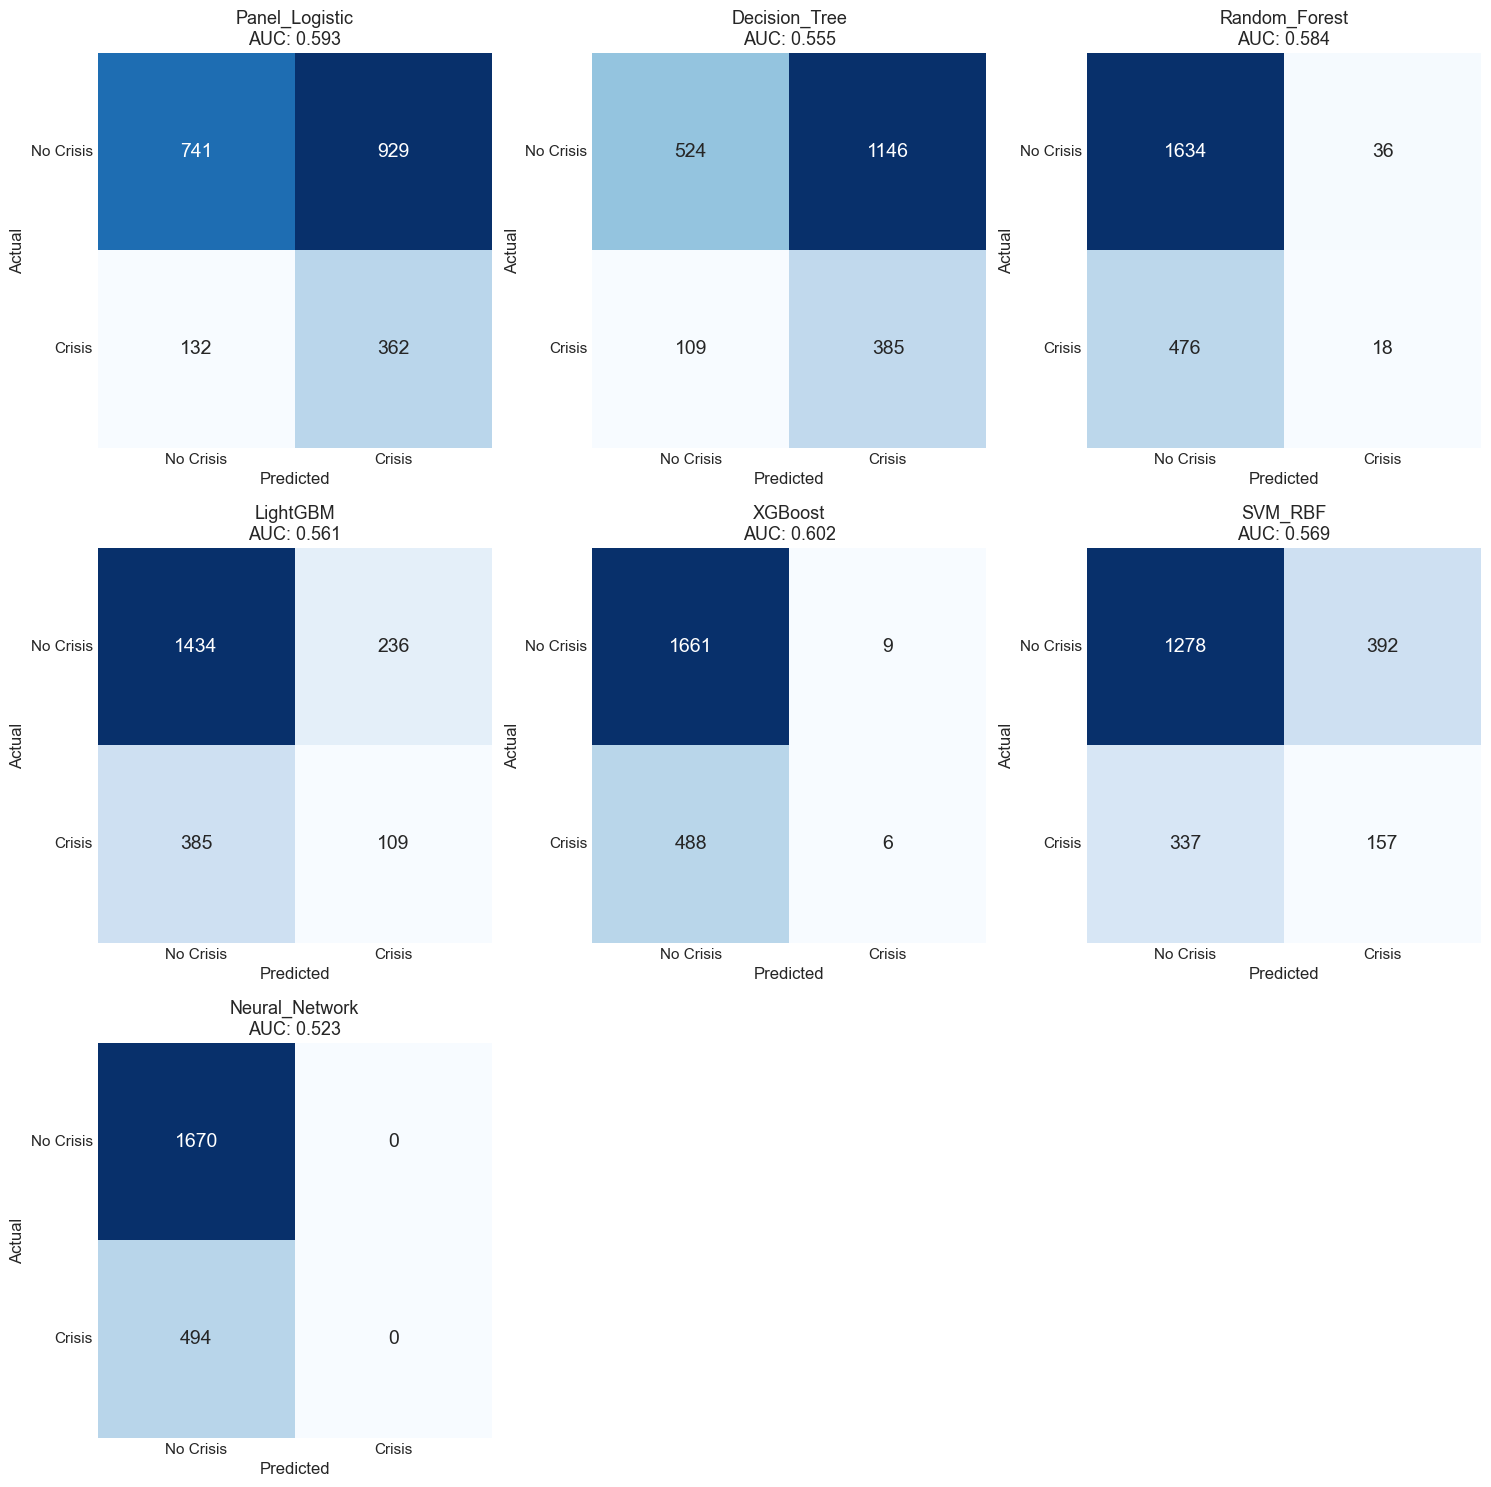

In [50]:
# Create confusion matrix visualization for all models
import matplotlib.pyplot as plt
import seaborn as sns

IMAGES_PATH = "../images"
os.makedirs(IMAGES_PATH, exist_ok=True)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for idx, (model_name, model_data) in enumerate(all_models.items()):
    cm = model_data['tuned_metrics']['Confusion_Matrix']
    ax = axes[idx]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                cbar=False, square=True, annot_kws={'size': 14})
    
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_title(f'{model_name}\nAUC: {model_data["tuned_metrics"]["AUC"]:.3f}', fontsize=13)
    ax.set_xticklabels(['No Crisis', 'Crisis'], fontsize=11)
    ax.set_yticklabels(['No Crisis', 'Crisis'], fontsize=11, rotation=0)

for idx in range(len(all_models), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_PATH, 'confusion_matrices.png'), dpi=300, bbox_inches='tight')
plt.show()

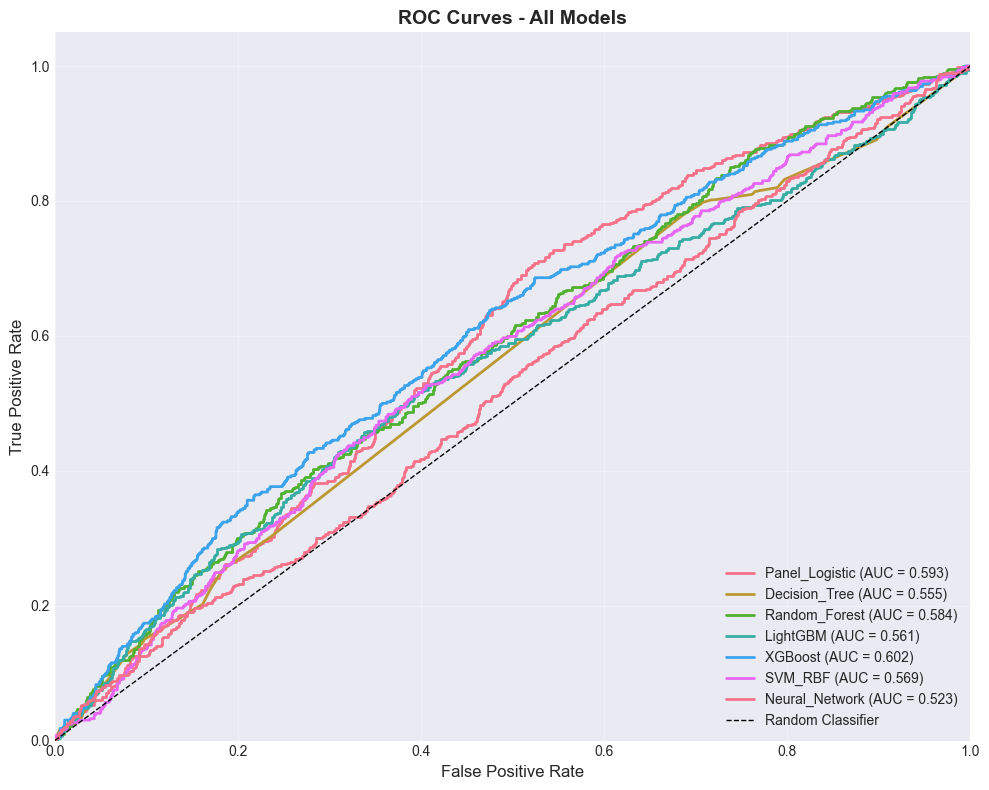

In [51]:
# Create ROC-AUC curves for all models
from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots(figsize=(10, 8))

for model_name, model_data in all_models.items():
    model = model_data['best_model']
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - All Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_PATH, 'roc_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

COST-BASED THRESHOLD OPTIMIZATION

Cost Structure:
  False Positive (False Alarm):  1
  False Negative (Missed Crisis): 10


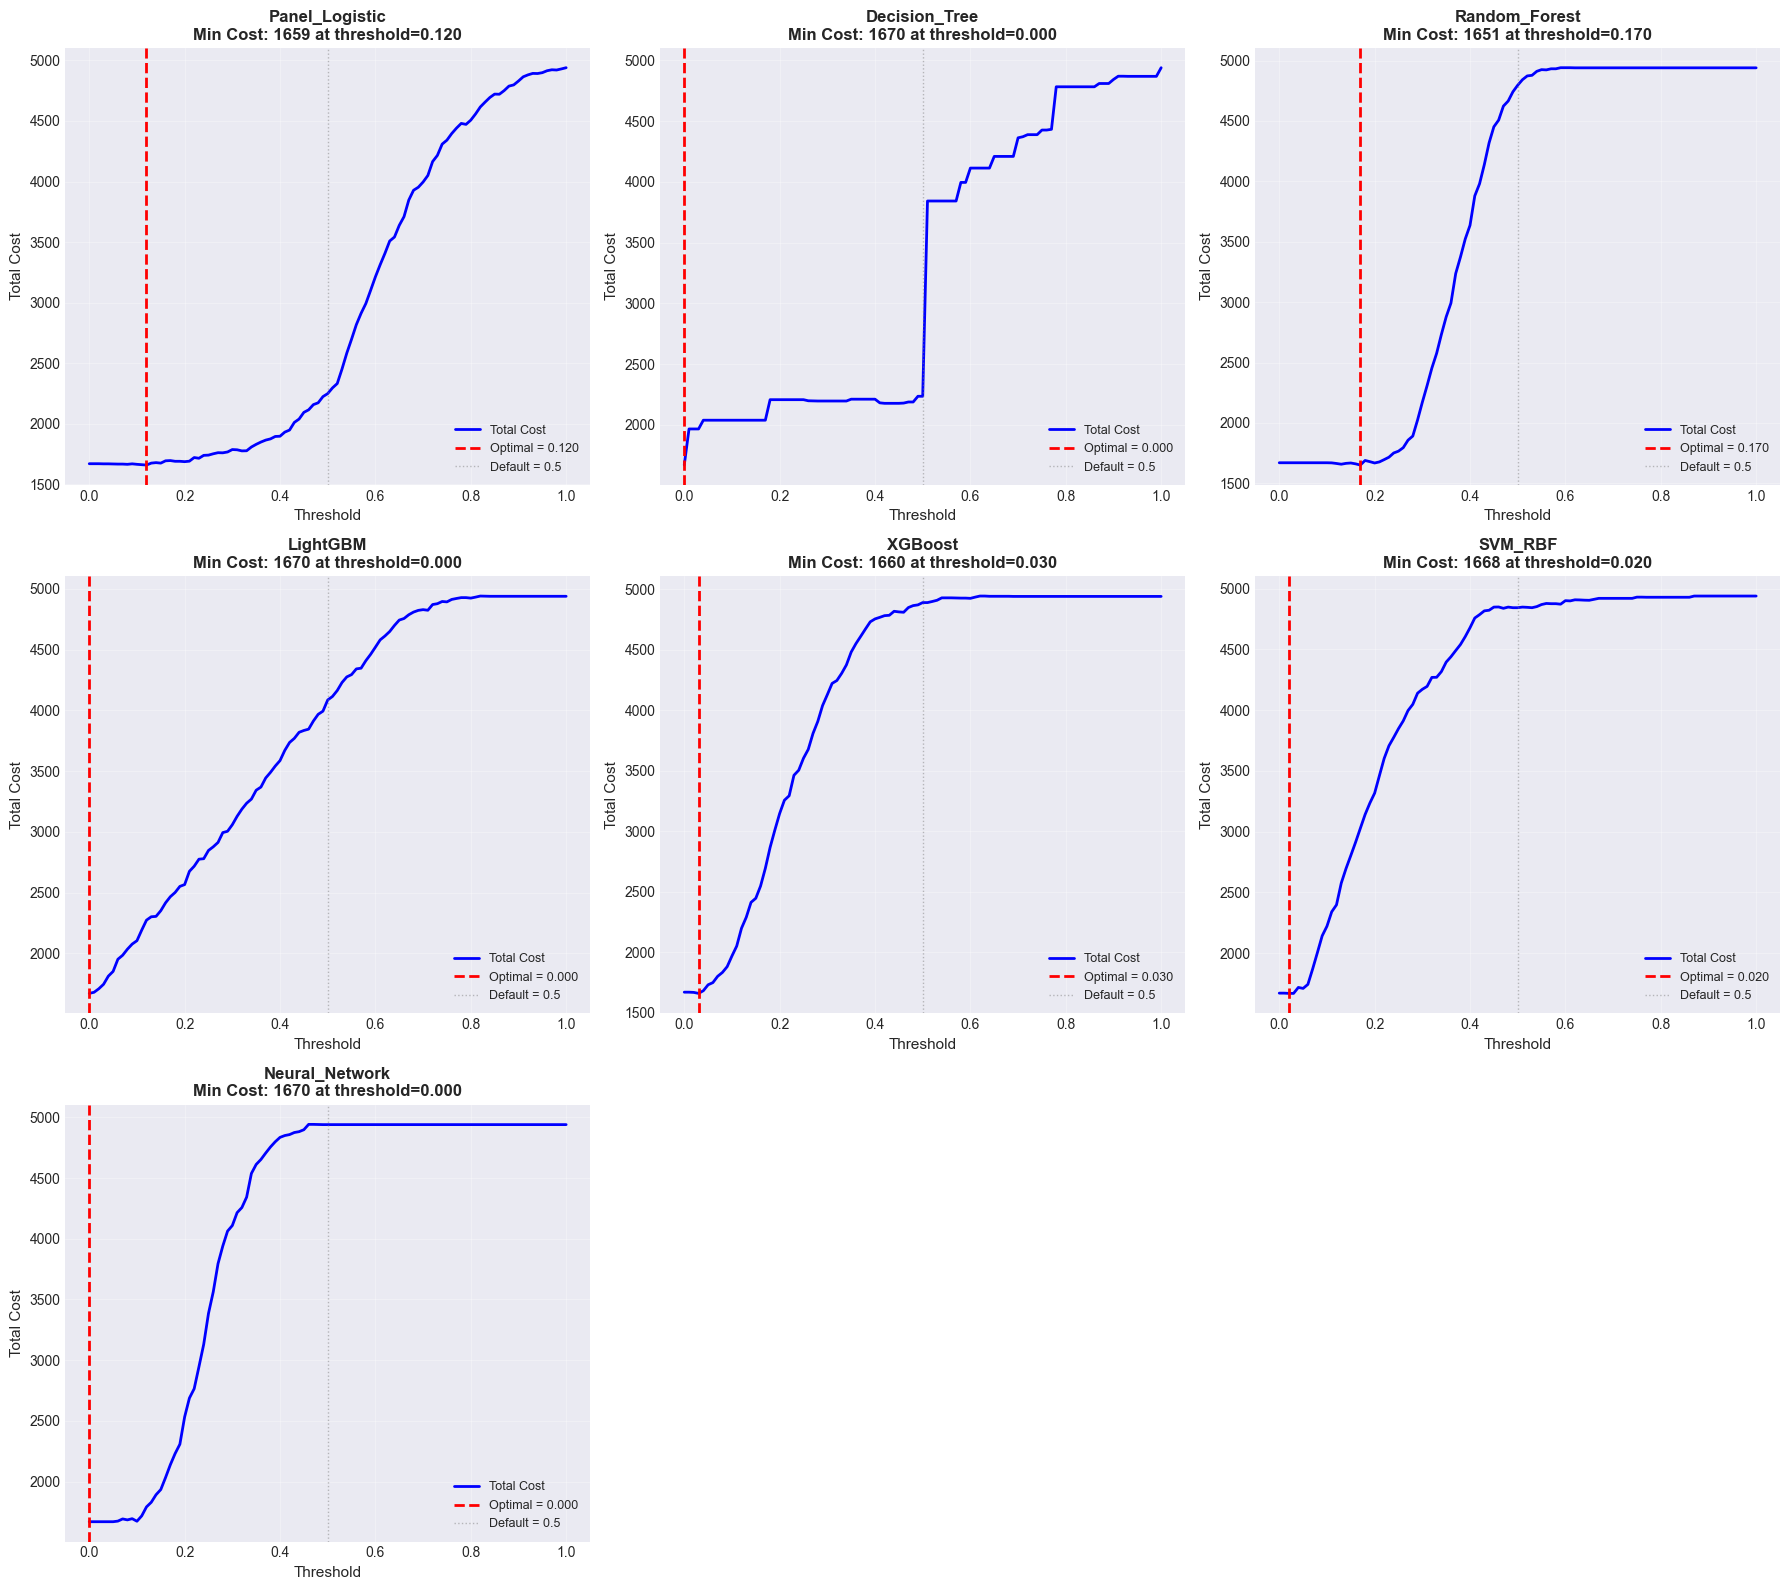


OPTIMAL THRESHOLDS SUMMARY

Model                Optimal Threshold  Min Cost   FP     FN    
--------------------------------------------------------------------------------
Random_Forest        0.170              1651      1631   2     
Panel_Logistic       0.120              1659      1649   1     
XGBoost              0.030              1660      1660   0     
SVM_RBF              0.020              1668      1668   0     
Decision_Tree        0.000              1670      1670   0     
LightGBM             0.000              1670      1670   0     
Neural_Network       0.000              1670      1670   0     

BEST MODEL (Cost-Optimized): Random_Forest
  Optimal Threshold: 0.170
  Minimum Total Cost: $1651
  False Positives: 1631
  False Negatives: 2


In [58]:
# Cost-Based Threshold Optimization
print("="*80)
print("COST-BASED THRESHOLD OPTIMIZATION")
print("="*80)

# Define costs
COST_FP = 1   # Cost of false alarm (predicting crisis when there is none)
COST_FN = 10  # Cost of missing a crisis (predicting no crisis when there is one)

print(f"\nCost Structure:")
print(f"  False Positive (False Alarm):  {COST_FP}")
print(f"  False Negative (Missed Crisis): {COST_FN}")

# Function to calculate total cost for a given threshold
def calculate_cost(y_true, y_proba, threshold, cost_fp, cost_fn):
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = (fp * cost_fp) + (fn * cost_fn)
    return total_cost, fp, fn

# Analyze cost for each model
fig, axes = plt.subplots(3, 3, figsize=(18, 16))
axes = axes.flatten()

optimal_thresholds = {}

for idx, (model_name, model_data) in enumerate(all_models.items()):
    model = model_data['best_model']
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Test thresholds from 0 to 1
    thresholds = np.linspace(0, 1, 101)
    costs = []
    fp_counts = []
    fn_counts = []
    
    for thresh in thresholds:
        cost, fp, fn = calculate_cost(y_test, y_proba, thresh, COST_FP, COST_FN)
        costs.append(cost)
        fp_counts.append(fp)
        fn_counts.append(fn)
    
    # Find optimal threshold (minimum cost)
    optimal_idx = np.argmin(costs)
    optimal_threshold = thresholds[optimal_idx]
    min_cost = costs[optimal_idx]
    
    optimal_thresholds[model_name] = {
        'threshold': optimal_threshold,
        'cost': min_cost,
        'fp': fp_counts[optimal_idx],
        'fn': fn_counts[optimal_idx]
    }
    
    # Plot cost curve
    ax = axes[idx]
    ax.plot(thresholds, costs, linewidth=2, color='blue', label='Total Cost')
    ax.axvline(optimal_threshold, color='red', linestyle='--', linewidth=2, 
               label=f'Optimal = {optimal_threshold:.3f}')
    ax.axvline(0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5, 
               label='Default = 0.5')
    
    ax.set_xlabel('Threshold', fontsize=11)
    ax.set_ylabel('Total Cost', fontsize=11)
    ax.set_title(f'{model_name}\nMin Cost: {min_cost:.0f} at threshold={optimal_threshold:.3f}', 
                 fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

for idx in range(len(all_models), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_PATH, 'cost_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print optimal thresholds summary
print("\n" + "="*80)
print("OPTIMAL THRESHOLDS SUMMARY")
print("="*80)
print(f"\n{'Model':<20} {'Optimal Threshold':<18} {'Min Cost':<10} {'FP':<6} {'FN':<6}")
print("-"*80)

for model_name, opt in sorted(optimal_thresholds.items(), key=lambda x: x[1]['cost']):
    print(f"{model_name:<20} {opt['threshold']:<18.3f} {opt['cost']:<9.0f} {opt['fp']:<6d} {opt['fn']:<6d}")

# Find best model based on cost
best_cost_model = min(optimal_thresholds.items(), key=lambda x: x[1]['cost'])
print(f"\n" + "="*80)
print(f"BEST MODEL (Cost-Optimized): {best_cost_model[0]}")
print(f"  Optimal Threshold: {best_cost_model[1]['threshold']:.3f}")
print(f"  Minimum Total Cost: ${best_cost_model[1]['cost']:.0f}")
print(f"  False Positives: {best_cost_model[1]['fp']}")
print(f"  False Negatives: {best_cost_model[1]['fn']}")
print("="*80)